# Preprocessing & Calculate FCS and HDDS From Household Survey Data Of Tanzania

In this Python notebook, we will explore the process of preprocessing household survey data from Tanzania to compute two food security indicators: **Food Consumption Score (FCS)** and **Household Dietary Diversity Score (HDDS)**. These indicators play a crucial role in assessing food security and nutritional status at the household level. The aim of calculating these indicators is to use them as ground truth data in the research project of using machine learning and deep learning for prediction for security indicators(FCS and HDDS) from heterogenous data.


### Food Security Indicators
    
These are quantitative measures used to evaluate the accessibility, availability, and utilization of food at various levels starting from households,community to the national level. These indicators provide insights into the extent and severity of food insecurity, helping policymakers, researchers, and practitioners to identify vulnerable populations and design targeted interventions. There are numbers of food security indicators however as we mentioned early we will only focus on two indicators which are **Food Consumption Score(FCS)** and **Household Dietary Diversity Score(HDDS)**. The details description of these indicators will be given to the [Computation of FCS and HDDS](#compute_fcs_hdds) section.
    


### About Tanzania
    
Tanzania is a country located in East Africa,it's economy is primarily driven by agriculture,despite being an agricultural country, Tanzania faces challenges with malnutrition and lack of dietary diversity, particularly in rural areas.Many households rely heavily on staple crops such as maize, rice, and cassava, leading to a limited variety in diets and micronutrient deficiencies. Also poverty remains a significant barrier that makes many households struggle to afford an adequate and nutritious diet. Apart from that limited access to markets, infrastructure, and transportation exacerbates food insecurity, particularly in remote and rural areas.
    

### Data Source

We will be working with National Panel Survey (NPS) data from Tanzania which are public available on [National Bureau of Statistics (NBS)](https://www.nbs.go.tz/index.php/en/)
. The NPS is a household survey conducted at a national level, offering insights into poverty levels, agricultural productivity, and various crucial development metrics. It's characterized as an "integrated" survey because it encompasses diverse subjects within a single questionnaire, spanning from education and healthcare to issues like crime, gender-based violence and food security. Since our topic is concering about food security we will only focus on the data which are relevant to our topic.

#### The following are the datasets that we will work with:

* [National Panel Survey(NPS) 2008 - 2009](https://microdata.worldbank.org/index.php/catalog/76)

* [National Panel Survey(NPS) 2010 - 2011](https://microdata.worldbank.org/index.php/catalog/1050)

* [National Panel Survey(NPS) 2012 - 2013](https://microdata.worldbank.org/index.php/catalog/2252)

* [National Panel Survey(NPS) 2014 - 2015](https://microdata.worldbank.org/index.php/catalog/2862)

* [National Panel Survey(NPS) 2019 - 2020](https://microdata.worldbank.org/index.php/catalog/3885)

* [National Panel Survey(NPS) 2020 - 2021](https://microdata.worldbank.org/index.php/catalog/5639)
* [High Frequency Welfare Monitoring Phone Survey 2021-2024](https://microdata.worldbank.org/index.php/catalog/4542)

## Import Libraries

In this section, we import essential libraries and modules required for data preprocessing, analysis, and visualization tasks. These libraries provide robust functionalities and tools that streamline the data analysis workflow and enable us to manipulate and explore the dataset efficiently.

In [1]:
#uncomment to install the libraries
#!pip install savReaderWriter
#!pip install geopandas
#!pip install pyreadstat
#!pip install seaborn
#!pip install folium
#!pip install plotly
#!pip install ipywidgets

In [2]:
import pandas as pd
import pyreadstat as ps
from pandas import read_csv
import savReaderWriter as sv
import numpy as np
import seaborn as sns
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
from ipywidgets import interact, IntSlider
from branca.colormap import LinearColormap

## <a id='helper_function'></a> Helper Function

In this section we define a set of helper functions designed to streamline data preprocessing tasks and facilitate the computation of Food Consumption Score (FCS) and Household Dietary Diversity Score (HDDS). These functions are designed to assist in converting dataset files from different formats to a common format (i.e., .csv), making them compatible with various data analysis tools and workflows.

In [3]:
def decode_value(value):
    
    '''
    This function decodes bytes to string and handles integer values.
    It checks if the input value is a bytes object and decodes it to a UTF-8 encoded string.
    If the value is a float and represents an integer, it converts it to an integer.
    Otherwise, it returns the original value.
    It is important while converting the .sav file to .csv.
    
    '''
    
    if isinstance(value, bytes):
        return value.decode('utf-8')
    elif isinstance(value, float) and value.is_integer():
        return int(value)
    else:
        return value

In [4]:
def sav_to_csv(sav_path,csv_path):
    
    '''
    This function converts a .sav (SPSS) file to a .csv (comma-separated values) file.
    It reads the .sav file using sv.SavReader, extracts column names, and decodes values using the decode_value function.
    The data is then converted to a DataFrame and saved as a .csv file at the specified path.
    '''
    
    with sv.SavReader(sav_path) as reader:
        # Extract the column names
        column_names = [name.decode('utf-8') for name in reader.header]
        
        # Read the data and decode values
        data = [[decode_value(value) for value in row] for row in reader]
    
    df = pd.DataFrame(data, columns=column_names)
    df.to_csv(csv_path, index=False)
    print(f"A new dataset is saved to {csv_path}")

In [5]:
def dta_to_csv(dta_path, csv_path):
    
    '''
    This function converts a .dta (Stata) file to a .csv file.
    It reads the .dta file using pd.read_stata and loads it into a DataFrame.
    The DataFrame is then saved as a .csv file at the specified path
    
    '''
    
    df = pd.read_stata(dta_path)
    df.to_csv(csv_path, index=False)
    print(f"A new dataset is saved to {csv_path}")

In [6]:
def subset_and_save(df, columns_to_keep, output_file, rename_columns=None):
    
    '''
    This function is designed to subset a DataFrame based on specified columns, add a year column
    and save the resulting subset to a new CSV file. 
    This function is helful when your dataset have a large number of columns and you only need to work with some of them.
    
    Parameters:
        df (DataFrame): The original DataFrame.
        columns_to_keep (list): A list of column names to keep.
        output_file (str): The path to the output CSV file.
        rename_columns (dict, optional): A dictionary where keys are original column names and values are new names.
        
    '''
    
    # Selecting columns to keep
    df_subset = df[columns_to_keep]

    # Optionally renaming columns
    if rename_columns:
        df_subset = df_subset.rename(columns=rename_columns)
    
    # Save the subset DataFrame to a new CSV file
    df_subset.to_csv(output_file, index=False)

    print(f"A new dataset is saved to {output_file}")

In [7]:
def merge_data(df_loc,df_fcs,df_hdds):
    '''
    Merge three data frames based on 'hhid' column using left join.

    Parameters:
        df_loc (DataFrame): First data frame containing the address of the household.
        df_fcs (DataFrame): Second data frame containing the fcs.
        df_hdds (DataFrame): Third data frame containing the hdds.

    Returns:
        DataFrame: Merged data frame.
    '''

    # Merge based on 'hhid' column
    merged_df = pd.merge(df_fcs, df_loc[['hhid', 'year', 'region', 'district', 'original_year']], on='hhid', how='left')
    merged_df = pd.merge(merged_df, df_hdds[['hhid', 'hdds']], on='hhid', how='left')

    # Reorder columns
    merged_df = merged_df[['original_year', 'year', 'hhid', 'region', 'district', 'fcs', 'hdds']]

    return merged_df


In [8]:
def concatenate_data(*dataframes):
    
    '''
    Concatenate multiple DataFrames provided by the user.

    Parameters:
    *dataframes (DataFrame): Variable number of DataFrame objects.

    Returns:
    DataFrame: Concatenated DataFrame.
    
    '''
    concatenated_df = pd.concat(dataframes)
    return concatenated_df

##### Sanity Check Function
A sanity check is aimed to remove all the household with **0** value in all food groups, we are doing this to prevent the biasing of the food consumption score upon aggregating them on a district and region level. Our assumption here is that it is impossible for a person to not eat anything for the past 7 days.

In [9]:
def sanity_check(df, columns):
    
    ''''
    Check if all specified columns in the dataframe have a value of 0.
    If so, drop those rows permanently and inform the user about the number of deleted rows.

    Parameters:
    - df: DataFrame to be checked
    - columns: List of column names to be checked for zero values

    Returns:
    - None
    
    '''
    # Check if all specified columns have value 0
    mask = df[columns].eq(0).all(axis=1)
    
    # Count number of rows to be deleted
    num_deleted_rows = mask.sum()
    
    if num_deleted_rows > 0:
        # Drop rows where all specified columns have value 0
        df.drop(df[mask].index, inplace=True)
        print(f"{num_deleted_rows} row(s) with all specified columns being 0 have been deleted.")
    else:
        print("No rows have been deleted.")

## Visualization Function

In this section of the notebook, we are creating variety of visualization functions that will effectively illustrate and explore the underlying data. These visualizations will offer insightful perspectives on the dataset, enabling clear interpretation and analysis of our data visually by examining trends, distributions,correlation and spatial relationships. We will create basic plots like histograms and scatter plots to more advanced visualizations such as heatmaps and interactive charts.....

In [10]:
def plot_food_consumption(df,year=None, save_path=None):
    
    '''
    Plots the dietary patterns by food consumption score.

    Parameters:
    - df (pd.DataFrame): DataFrame containing columns for food consumption score ('fcs') 
                         and consumption frequency of different food groups.
    - year (str or int, optional): Year to be added to the plot title.
    - save_path (str, optional): Path to save the plot image. If None, the plot will be displayed but not saved.                     

    Returns:
    - None
    
    '''
    
    # Sort the dataframe by 'fcs' if not already sorted
    df.sort_values('fcs', inplace=True)
    
#     plt.figure(figsize=(30,40))

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.stackplot(df['fcs'], df[['animal_protein', 'cereals_tubers',
                             'dairy_products', 'fruits', 'oil', 'pulses_nuts', 
                             'sugar', 'vegetables_leaves']].T,
             labels=['Animal Protein', 'Cereals & Tubers','Dairy Products',
                     'Fruits', 'Oil', 'Pulses & Nuts', 
                     'Sugar', 'Vegetables & Leaves'])

    # Customize the plot
    ax.legend(loc='upper left')
    title = 'Dietary Patterns by Food Consumption Score'
    if year:
        title += f' {year}'
    ax.set_title(title)
    ax.set_xlabel('FCS')
    ax.set_ylabel('Comulative Consumption Frequency')
    
    max_fcs = max(df['fcs'])
    ax.set_xticks([x for x in range(0, int(max_fcs) + 1, 10) if x <= max_fcs])
    
    # Save the plot
    if save_path:
        plt.savefig(save_path)
    
    # Display the plot
    plt.show()


In [11]:
def visualize_fcs_with_oil_sugar(df, year=None, save_path=None):
    
    ''''
    Visualize the relationship between sugar and oil consumption with respect to FCS.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the relevant columns.
    - year (int or str, optional): Year to include in the title. Default is None.
    - save_path (str, optional): Path to save the plot. Default is None.

    Returns:
    - None
    '''
    # Group by FCS and calculate the mean sugar and oil consumption
    fcs_avg = df.groupby('fcs')[['sugar', 'oil']].mean().reset_index()
    
    # Plot the relationship
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=fcs_avg, x='fcs', y='sugar', label='Sugar')
    sns.lineplot(data=fcs_avg, x='fcs', y='oil', label='Oil')
    
    # Set labels and title
    plt.xlabel('FCS')
    plt.ylabel('Average Consumption')
    
    # Include year in the title if provided
    if year:
        plt.title(f'The Consumption of Sugar and Oil with Respect to FCS - {year}')
    else:
        plt.title('The Consumption of Sugar and Oil with Respect to FCS')  
    
    # Add legend
    plt.legend()
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


In [12]:
def calculate_fcs_percentages(dataframe, year=None, save_path=None):
    
    '''
    Calculate the percentages of households falling into different FCS categories and visualize the distribution.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing FCS data.
    - year (int or str, optional): Year to include in the title. Default is None.
    - save_path (str, optional): Path to save the plot. Default is None.

    Returns:
    - None
    
    '''
    # Calculate the number of households falling into each category
    poor_count = len(dataframe[dataframe['fcs'] <= 21])
    borderline_count = len(dataframe[(dataframe['fcs'] > 21) & (dataframe['fcs'] <= 35)])
    acceptance_count = len(dataframe[dataframe['fcs'] > 35])

    # Calculate percentages
    total_households = len(dataframe)
    poor_percentage = (poor_count / total_households) * 100
    borderline_percentage = (borderline_count / total_households) * 100
    acceptance_percentage = (acceptance_count / total_households) * 100

    # Plot pie chart
    labels = ['Poor', 'Borderline', 'Acceptance']
    sizes = [poor_percentage, borderline_percentage, acceptance_percentage]
    colors = ['red', 'orange', 'green']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    if year:
        plt.title(f'Distribution of Food Consumption Score (FCS) - Year {year}')
    else:
        plt.title('Distribution of Food Consumption Score (FCS)')

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)

    plt.show()

In [13]:
def visualize_samples_distribution(df, year=None, save_path=None):
    
    '''
    Visualize the distribution of the 'count' variable using a histogram with density.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the 'count' variable.
    - year (int or str, optional): Year to include in the title. Default is None.
    - save_path (str, optional): Path to save the plot. Default is None.

    Returns:
    - None
    
    '''
    # Create a figure and axis
    plt.figure(figsize=(8, 6))

    # Plot histogram with density
    sns.histplot(df['count'], kde=True)
    plt.xlabel('Number of Household Samples')
    plt.ylabel('Frequency')

    # Include year in the title if provided
    if year:
        plt.title(f'Distribution of Household Samples - {year}')
    else:
        plt.title('Distribution of Household Samples')
        
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)

    plt.show()


## <a id='compute_fcs_hdds'></a> Computation of FCS and HDDS

In this section, we will explain how we will compute the **Food Consumption Score (FCS)** and the **Household Dietary Diversity Score (HDDS)**. Since we will work of multiple dataset in our study area, we will adopt a standardized approach for calculating both FCS and HDDS across all datasets. Regardless of the dataset's specific characteristics, we will apply consistent methods to ensure comparability and reliability of the results.

###  <a id='fcs'></a>1. Food Consumption Score (FCS)

The Food Consumption Score (FCS) is a food security indicator developed by the [World Food Programme (WFP)](https://resources.vam.wfp.org/data-analysis/quantitative/food-security/food-consumption-score). It serves as an essential index for assessing household food consumption patterns and nutritional adequacy. The data to compute the FCS are collected by household survey questionnaire by asking a respondent the list of food groups they have consumed for the past seven days. The FCS aggregates these data on the diversity and frequency of food groups consumed over the previous seven days **(7)** which is then weighted according to the relative nutritional value of the consumed food groups as specified in the table below.

<p><img src="images/food_weights.png"  align="centre" alt="food groups weighs" style="width:600px;height:300px;"></p>


#### Steps to Compute FCS
 1. Group food items in the specified food groups
 2. Sum all the consumption frequencies of food items within the same group but the maximum limit should be 7
 3. Multiply the value of each food group by its weight as explained in table
 4. Sum the weighted food group scores to obtain the overall FCS
 5. After computing the food consumption score, it's essential to establish thresholds for the Food Consumption Groups (FCGs)
     
##### Mathematically the FCS is represented as:

$$
FCS = \sum_{j=1}^{9}f_j \times x_j
$$

**Where:**

- $(f_j$) represents the frequency of consumption of food group $(j$).
- $(x_j$) represents the nutritional value (weight) of food group $(j$).
- $(j$) ranges from 1 to 9, representing the nine food groups considered in the calculation.

#### Food Consumption Group(FCGs) 

As explained earlier in step (5) above that after computing the overall food consumption score we need to choose the threshold to clasify the household either they are in poor, bordeline or acceptable.

**World Food Program** suggest the following threshold to set the FCGs

   * 0 - 21 : Poor
   * 21.5 - 35 : Borderline
   * &gt; 35 : Acceptable
     
However, it's essential to assess these thresholds and potentially adjust them according to the context and dietary habits of the population under consideration.The objective is to select thresholds that precisely reflect the choosen context.

**Issues of Sugar and oil in choosing FCGs thresholds**

In certain populations, such as in Mali as reported by the World Food Programme (WFP), the consumption of sugar and/or oil is widespread, with nearly all households consuming these items daily for 7 days. Despite both sugar and oil having a weight of 0.5, their combined consumption raises the FCS to a base score of 7. When this base score is combined with frequent starch consumption the FCS reaches 21 which is not even represent a bordeline diet.Therefore choosing the threshold of 21 and 35 will not a yiled a correct results and may lead to incorrect anlaysis. To address such issues in these populations the adjustments to the threshold are necessary, one way is by raising the thresholds from 21 and 35 to 28 and 42 respectively. Therefore the new threshold for FCGs will be:

   * 0 - 28 : Poor
   * 28.5 - 42 : Borderline
   * &gt; 42 : Acceptable

However in populations with heterogeneous patterns of oil and sugar consumption adjusting thresholds may not be effective a case of Sudan as explained by [WFP VAM](https://documents.wfp.org/stellent/groups/public/documents/manual_guide_proced/wfp197216.pdf). The best way to deal with this issues is to exclude oil and sugar consumption from FCS calculation and maintain thresholds at 21 and 35. While this approach introduces a downward bias and overlooks the dietary significance of oil and sugar, it facilitates smoother comparison of FCS between populations.

#### Sum Up Frequency by Food Group  Function (SFFGF)

This function implement the **Step 1** and **Step 2** as explained above.
It Groups all the food items to its corresponding food groups and compute the sum of all the consumption frequencies.Some survey  data are already accomodate this steps, so you dont have to do this steps if the data that you are working with are provided in food group based and not food items this. 
After computing the sum of each group the upper limit of the food frequency of each food groups is set to a maximum of 7(representing the number of days) as suggested by [WFP VAM](https://documents.wfp.org/stellent/groups/public/documents/manual_guide_proced/wfp197216.pdf). to prevent biasing the score upwards. This approach is used to prevent the bias of the score when there is an increasing of the number of food items/groups used in questionnaire(and later collapsed into the food groups for the FCS calculation). Assuming the questionnaire gathers the consumption of maize, rice,wheat and these foods are all consumed in combinatination on the same days, let say the frequency of maize=3, rice=3, wheat=3, all of these fall into the food group of cereals then the frequency of the cereals will be 9, thus biasing the score. We use this appoach beacuse the data that we are working with uses a large number of food items in the survey.

In [14]:
def sum_up_frequency_by_food_group(data):
    
    '''
    Processes the given DataFrame by grouping by 'hhid' and 'food_group',
    summing up 'is_consumed', pivoting the data to get food groups as columns, and
    ensuring that no aggregated sum exceeds 7.

    Parameters:
    - data (pd.DataFrame): The input DataFrame with at least 'hhid','food_group', and 'is_consumed' columns.
    - hhid: represent a unique identifier of each household
    - food_groups: containing the food group such as cereal,pulses,sugar, oil, etc
    - is_consumed: represent an integer value of number of days in which a certain food group is consumed for the past 7 days

    Returns:
    - pd.DataFrame: A pivoted DataFrame with 'hhid' as rows, 'food_group' as columns,
                    and sum of 'is_consumed' as values, capped at a maximum of 7.
                    
    '''
    # Group by 'hhid', 'food_group',then sum up 'is_consumed'
    grouped_data = data.groupby(['hhid', 'food_group'])['is_consumed'].sum().reset_index()

    # Pivot the data to get food groups as columns
    pivot_data = grouped_data.pivot_table(index='hhid', columns='food_group', values='is_consumed', aggfunc='sum', fill_value=0)

    # Reset index to make 'hhid' a column again
    pivot_data.reset_index(inplace=True)

    # Set the maximum number of days to be 7 for all columns except 'hhid'
    pivot_data.iloc[:, 1:] = pivot_data.iloc[:, 1:].applymap(lambda x: min(x, 7))

    return pivot_data

#### Calculate Food Consumption Score Function (CFCSF)

This function compute the food consumption score of a given dataframe. It implements the instruction of **Step 1** to **Step 4**  to compute the overall score. The weights of each food group is defined as explained in the section above. There are two version of this function, **calculate_fcs_version1()** only return the hhid and the computed food consumption score(fcs) and the other one is **calculate_fcs_version2()** which return the hhid, the columns of each food groups with their aggregated frequency and the calculated the food consumption score. Both of these methods produce the same score for the fcs but diffrent is only on the returned dataframe. So the choice of which one you want to use depends with your goals.

In [15]:
def calculate_fcs(data):
    '''
    Processes the given DataFrame by summing up the frequency of food consumption for each household,
    performing a sanity check to delete all the rows with 0 values in all food groups,assigning weights to each food group, and
    calculating the food consumption score (FCS) for each household.

    Parameters:
    - data (pd.DataFrame): Input DataFrame with 'hhid' and columns representing different food groups.
    
    Returns:
    - pd.DataFrame: Output DataFrame with each 'hhid', the aggregated values for each food group,
                    and the calculated FCS.
    '''
    # Sum up the frequency of food consumption for each household
    data_final = sum_up_frequency_by_food_group(data)
    
    # Perform a sanity check, if you dont want to delete all the rows with 0 value commenton the call of function below
    # Columns to be checked for 0 values
    cols=['animal_protein','cereals_tubers','condiments','dairy_products','fruits','oil','pulses_nuts','sugar','vegetables_leaves']
    sanity_check(data_final,cols)
    
    # Define weights for each food group
    weights = {
        'cereals_tubers': 2,
        'pulses_nuts': 3,
        'vegetables_leaves': 1,
        'fruits': 1,
        'animal_protein': 4,
        'dairy_products': 4,
        'sugar': 0.5,
        'oil': 0.5,
        'condiments': 0
    }
    
    # Compute the FCS by applying weights to the food group values and summing them up
    fcs = data_final.copy()
    for food_group in weights:
        if food_group in fcs.columns:
            fcs[food_group] = fcs[food_group] * weights[food_group]
    
    data_final['fcs'] = fcs.iloc[:, 1:].sum(axis=1)
    
    return data_final


### 2. Household Dietary Diversity Score (HDDS)

Household dietary diversity Score (HDDS) is a qualitative measure of food consumption that reflects household access to a variety of foods that indicate dietary diversity and nutritional quality.The HDDS consists of a simple count of food groups that a household has consumed over the preceding 24 hours. Each food group is assigned a score of **1 (if consumed over the previous 24 hours)** or **0 (if not consumed in the last 24 hours)**. The household score will range between 0 to 12 and is equal to the total number of food groups consumed by the household.

##### The following 12 food groups are used to calculate the HDDS indicator:

<img src="images/hdds_groups.png"  align="centre" alt="food groups weighs" style="width:400px;height:200px;">

#### Steps to Compute HDDS
 1. Group food items in the specified food groups
 2. Sum all the consumption frequencies of food items within the same group but the maximum limit should be 1
 3. Sum the food group scores to obtain the overall HDDS.

##### Mathematically the HDDS is represented as: 
$$
HDDS = \sum_{j=1}^{12} x_j
$$

where $( x_j $) equals 1 if the household consumed food from group $( j $) in the past 24 hours, and 0 otherwise.



#### Calculate Household Dietary Diversity Score Function (CHDDSF)
This function compute the household dietary diversity score for a given data frame. 

In [16]:
def calculate_hdds(data):
    '''
    Processes the given DataFrame by performing frequency summation, 
    performing a sanity check to delete all the rows with 0 values in all food groups
    Set the value of 1 to the columns with value greater than 0
    calculating Household Dietary Diversity Score (HDDS) by summing the values
    of all the columns present in each food group.

    Parameters:
    - data (pd.DataFrame): The input DataFrame with at least 'hhid','food_group', and 'is_consumed' columns.

    Returns:
    - pd.DataFrame: A DataFrame with 'hhid', the value of all the columns, and the summed results as HDDS
                    for each household.
                    
    '''

    # Perform frequency summation using sum_up_frequency_by_food_group
    data_final = sum_up_frequency_by_food_group(data)
    
    # Perform a sanity check, if you dont want to delete all the rows with 0 value commenton the call of function below
    # Columns to be checked for 0 values
    cols=['animal_protein','cereals_tubers','condiments','dairy_products','fruits','oil','pulses_nuts','sugar','vegetables_leaves']
    sanity_check(data_final,cols)
    
    # Set the value to 1 for all columns where the value is greater than 0
    data_final.iloc[:, 1:] = data_final.iloc[:, 1:].applymap(lambda x: 1 if x > 0 else 0)
    
    # Calculate Household Dietary Diversity Score (HDDS) by summing the values of all columns present in each food group
    data_final['hdds'] = data_final.drop(columns=['hhid']).sum(axis=1)

    return data_final

## Aggregation to District Level

After computing the FCS and HDDS for all households in our datasets, we aggregate these scores to the district level. This involves grouping households by their respective districts and calculating summary statistics such as the mean or weighted mean of the FCS and HDDS for each district.

Since each district may represent different number of samples, the mean of FCS and HDDS can be calculated as

$$
\text{mean} = \frac{\sum_{i=1}^{n} x_i}{n}
$$

Where:
- $(x_i$) represents the value of the variable (FCS or HDDS) for the $(i^{th}$) household.
- $(n$) is the total number of households in each district.


This formula can be used to calculate the mean of FCS and HDDS, taking into account the distribution of households samples across different district.


In [17]:
def calculate_mean(dataframe, group_by_columns, average_columns, additional_columns=None):
    
    '''
    Aggregate data in a DataFrame by specified columns and calculate the mean of one or more columns.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data to be aggregated.
    - group_by_columns (list): The list of column names to group the data by.
    - average_columns (list): A list of column names to calculate the average.
    - additional_columns (list, optional): A list of column names to include in the output DataFrame.

    Returns:
    pd.DataFrame: A new DataFrame containing the aggregated results with the following columns:
        - [average_columns]: The average values of the specified average_columns.
        - Count: The count of rows used to calculate the mean values.
        - Additional_columns (optional): The values of the specified additional_columns if provided.
    '''

    # Group by the specified columns and calculate the mean for each average column
    aggregated_data = dataframe.groupby(group_by_columns)[average_columns].mean().reset_index()
    # Round the mean values to 2 decimal points
    aggregated_data[average_columns] = aggregated_data[average_columns].round(2)

    # Calculate the count based on the first average column
    count_column = dataframe.groupby(group_by_columns)[average_columns[0]].count().reset_index()
    # Rename the count column
    count_column.rename(columns={average_columns[0]: 'count'}, inplace=True)

    # Merge the count column with the aggregated data
    aggregated_data = pd.merge(aggregated_data, count_column, on=group_by_columns)

    # If additional columns are specified, merge them into the aggregated DataFrame
    if additional_columns:
        for additional_column in additional_columns:
            additional_df = dataframe[group_by_columns + [additional_column]].drop_duplicates()
            aggregated_data = pd.merge(additional_df, aggregated_data, on=group_by_columns)

    # Reorder columns so that additional columns appear first
    if additional_columns:
        columns_order = group_by_columns + additional_columns + average_columns + ['count']
        aggregated_data = aggregated_data[columns_order]

    return aggregated_data

## General Notes for All the Dataset
In the next sections we will discuss about all the datasets we will use,where are they collected and some important details about the datasets. Before going further to our task there are important things to notes which are appliead to all the dataset that we are going to analyse later on and compute the FCS and HDDS score.

#### Preprocesing in OpenRefine
The following are some preprocessing tasks that are done on [OpenRefine](https://openrefine.org/download) softarwe:
* Deleting unrelevant columns and renaming the columns (This can also be done in the using subset_and_save() function available in [Helper Function Section](#helper_function)
* Renaming the files of the data
* Mapping the food items to their respective group as explained in [Food Consumption Score Section](#fcs)
* Reconciliation of Location of the household to match the Region and Districts name with those available in Tanzania Administrative Shapefiles. The shapefiles used in this work are collected in [GADM](https://gadm.org/download_country.html)
* Merging the Year as one session, Most of the survey invlove multi-year therefore the year is combine to represent the whole survey. eg if the survey is taking from August 2008 to September 2009. Then the year column is represented as 2008/2009.

#### Creating Maps in QGIS 
We use [QGis](https://www.qgis.org/en/site/forusers/download.html) Software to create maps to show the spatial distribution of the food consumption score in different administratives levels.By visualizing these scores on a map, we can effectively recognize the geographical variations in food consumption habits, identify areas with high or low food consumption scores, and understand the distribution of food consumption groups in our dataset. 

#### Note About Reconciliation of Administratives Boundaries
During the reconciliation process there are some districts available in the Survey but are missing in the shapefiles, and we figured out that this problem is attributed to ongoing changes in administrative boundaries within Tanzania and it appears that the shapefile had not been updated to reflect these recent administrative changes and by the time some of the surveys were conducted they were using the new districts. In most cases the districts are splits in to diffrent districts and some are merged as together.If we update the new administrative division in the shapefiles we would not properly exploit old survey data, so to deal with this problem we cross-referenced the existing districts in the shapefile with both old and new districts identified in the survey data and merged those that were initially on the same boundaries. [Here](https://www.citypopulation.de/en/tanzania/admin/) is the reference tool that uses the same idea to merged the new districts that were initial present in the single district.Also there is one district named **(Magharibi)** in all the datasets we have but in the shapefiles this district is split into two district **Magharibi A** and **Magharibi B**. Since there is no additional data in the survey to identify which households are from  **Magharibi A** and **Magharibi B**, we have merged the features of **Magharibi A** and **Magharibi B** in our shape files as a single feature named **Magharibi** as shown in the image below. Therefore for all the analysis we will do in our task we will use this new shapefile we have modifie.

<p><img src="images/merged.png"  align="centre" alt="The Merged District" style="width:500px;height:400px;"></p>


## National Panel Survey (October 2008) - (September 2009)

This dataset is public available on [National Panel Survey(NPS) 2008 - 2009](https://microdata.worldbank.org/index.php/catalog/76). The NPS interviewed 3,280 households spanning all regions and all districts of Tanzania, both mainland and Zanzibar.The dataset containing data related to Household questionnaire, Agriculture questionnaire and Community questionnaire which cover broad range of the topics. For more discription about the coverage of the topics in this dataset [Click Here](https://microdata.worldbank.org/index.php/catalog/76/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on file consisting about food consumption. For more description about the data definition of each files and their associate variables [Visit Here](https://microdata.worldbank.org/index.php/catalog/76/data-dictionary)



#### Loading the data sources

The data files we have use in the dataset are those named:
* SEC_A_T.dta : Contain the description about the address of the household which is identified by a unique identification (hhid)
* SEC_K1.dta : Contain the data information about food consumption of 7 days recall

These files are in stata format, therefore we need to change them into csv format for easily manipulation

In [18]:
#define data directory
dir_2008_2009 = 'Tanzania/2008_2009/tanzania_2008_2009_preprocessed_data/'

In [ ]:
'''
#convert SEC_A_T.dta to csv file

o_path= dir_2008_2009+'SEC_A_T.dta'
u_path = dir_2008_2009+ 'SEC_A_T.csv'

dta_to_csv(o_path,u_path) #call the function to convert

'''

'''
#convert SEC_K1.dta to csv file

o_path= dir_2008_2009+'/SEC_K1.dta'
u_path = dir_2008_2009+'/SEC_K1.csv'

dta_to_csv(o_path,u_path) #call the function to convert


'''

In [19]:
#Load the data file containing the food items consumed by each household the file is generated from SEC_K1.csv 
data =  read_csv(dir_2008_2009 +'tz_2008_2009_food_consumed.csv', header=0, delimiter=',')
data.head()

,hhid,food_items,is_consumed,food_group
0,1010140020171,Rice (paddy),0,cereals_tubers
1,1010140020171,Rice (husked),0,cereals_tubers
2,1010140020171,"Maize (green, cob)",0,cereals_tubers
3,1010140020171,Maize (grain),0,cereals_tubers
4,1010140020171,Maize (flour),0,cereals_tubers


In [20]:
#read the file containing the location of the household 
location =  read_csv(dir_2008_2009+'tz_2008_2009_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,hhid,year,original_year,region,district,locality
0,1,1010140020171,2008/2009,2008,Dodoma,Kondoa,Rural
1,1,1010140020284,2008/2009,2008,Dodoma,Kondoa,Rural
2,1,1010140020297,2008/2009,2008,Dodoma,Kondoa,Rural
3,1,1010140020409,2008/2009,2008,Dodoma,Kondoa,Rural
4,1,1010140020471,2008/2009,2008,Dodoma,Kondoa,Rural


#### Calculate FCS

In [21]:
data_fcs=calculate_fcs(data)

44 row(s) with all specified columns being 0 have been deleted.


#### Checking For Dietary Patterns of The Population

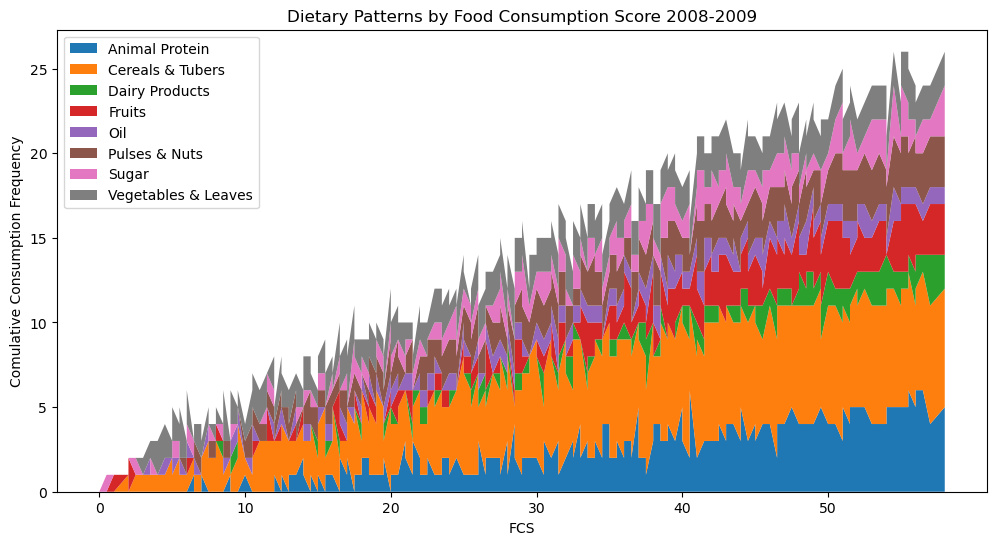

In [22]:
plot_food_consumption(data_fcs, year='2008-2009', save_path='Tanzania/graphs/dp2008_2009.png')

In [23]:
#save the file may be useful later
data_fcs.to_csv(dir_2008_2009 +'tz_2008_2009_fcs.csv', index=False)

#### Compute HDDS

In [24]:
#call the function to compute the hdds
data_hdds = calculate_hdds(data)
data_hdds.head()

44 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,hdds
0,1010140020171,1,1,1,1,0,1,0,1,1,7
1,1010140020284,0,1,1,0,0,1,0,0,1,4
2,1010140020297,1,1,1,1,0,1,1,1,1,8
3,1010140020409,1,1,1,0,0,1,0,1,1,6
4,1010140020471,0,1,1,0,0,1,1,1,1,6


In [25]:
#save the file may be useful later
data_hdds.to_csv(dir_2008_2009 +'tz_2008_2009_hdds.csv', index=False)

#### Combine the files

In [26]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,original_year,year,hhid,region,district,fcs,hdds
0,2009.0,2008/2009,10020113110083,Ruvuma,Songea Rural,0.0,1
1,2009.0,2008/2009,5030083210053,Morogoro,Kilombero,0.0,1
2,2008.0,2008/2009,14030160020262,Tabora,Uyui,0.0,1
3,2009.0,2008/2009,7030120480012,Dar es Salaam,Temeke,0.0,1
4,2009.0,2008/2009,5050020180044,Morogoro,Morogoro Urban,0.5,2
5,2008.0,2008/2009,7020090280091,Dar es Salaam,Ilala,0.5,2
6,2008.0,2008/2009,4010270041200,Tanga,Lushoto,1.0,1
7,2009.0,2008/2009,7010110660119,Dar es Salaam,Kinondoni,1.0,2
8,2009.0,2008/2009,21040020040396,Manyara,Simanjiro,2.0,1
9,2008.0,2008/2009,7010080430054,Dar es Salaam,Kinondoni,2.0,2


In [27]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2008_2009+'tz_2008_2009_merged_data.csv', index=False)

In [28]:
data_merged.shape

(3221, 7)

#### Compute the Mean FCS and HDDS of Each District

In [29]:
agg_data= calculate_mean(data_merged, ['year','region','district'],['fcs','hdds'])
agg_data.head()

,year,region,district,fcs,hdds,count
0,2008/2009,Arusha,Arusha,28.00,8.12,8
1,2008/2009,Arusha,Arusha Urban,31.45,8.33,39
2,2008/2009,Arusha,Karatu,23.63,7.47,15
3,2008/2009,Arusha,Meru,31.19,8.75,8
4,2008/2009,Arusha,Monduli,22.16,8.00,16


In [30]:
agg_data.shape

(131, 6)

#### Spatial Distribution of FCS 

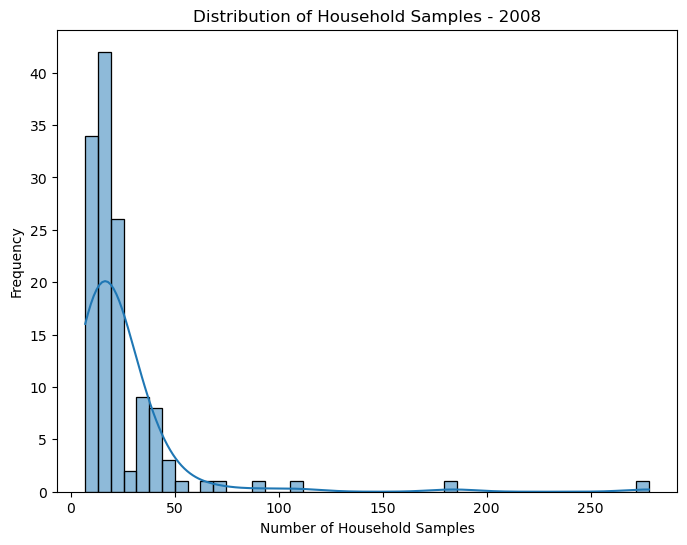

In [31]:
visualize_samples_distribution(agg_data,'2008')

In [32]:
#save the merged dataset may be useful later
agg_data.to_csv(dir_2008_2009+'tz_2008_2009_final_data.csv', index=False)

## National Panel Survey 2010 - 2011

This dataset is public available on [National Panel Survey(NPS) 2010 - 2011](https://microdata.worldbank.org/index.php/catalog/1050). The total sample size was 3,265 households in 409 Enumeration Areas (2,063 households in rural areas and 1,202 urban areas covering Dar es Salaam, other urban areas in Mainland, rural areas in Mainland, and Zanzibar.The dataset containing data related to Household questionnaire, Agriculture questionnaire, Fishery questionnaire and Community questionnaire which cover broad range of the topics. For more discription about the coverage of the topics in this dataset [Click Here](https://microdata.worldbank.org/index.php/catalog/1050/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.worldbank.org/index.php/catalog/1050/data-dictionary)

#### Loading the data sources

The data files we have use in the dataset are those named:

   * HH_SEC_A.dta : Contain the description about the address of the household which is identified by a unique identification (hhid)
    
   * HH_SEC_K2.dta : Contain data related to frequency of consumption of food items in the past 7 days.

These files are in stata format, therefore we need to change them into csv format for easily manipulation


In [33]:
#define data directory
dir_2010_2011 = 'Tanzania/2010_2011/tanzania_2010_2011_preprocessed_data/'

In [ ]:
'''
#convert HH_SEC_A.dta to csv file
o_path= dir_2010_2011+'HH_SEC_A.dta'
u_path = dir_2010_2011+ 'HH_SEC_A.csv'

dta_to_csv(o_path,u_path) #call the function to convert


#convert HH_SEC_K2.dta to csv file

o_path= dir_2010_2011+'HH_SEC_K2.dta'
u_path = dir_2010_2011+'HH_SEC_K2.csv'

dta_to_csv(o_path,u_path) #call the function to convert

'''

In [35]:
#Load the data file containing the food items consumed by each household the file is generated from HH_SEC_K2.csv 
data =  read_csv(dir_2010_2011+'tz_2010_2011_food_consumed.csv', header=0,delimiter=',')
data.head()

,hhid,food_code,food_group,is_consumed
0,101014002017101,A,cereals_tubers,7.0
1,101014002017101,B,cereals_tubers,0.0
2,101014002017101,C,pulses_nuts,2.0
3,101014002017101,D,vegetables_leaves,7.0
4,101014002017101,E,animal_protein,2.0


In [36]:
#read the file containing the location of the household 
location =  read_csv(dir_2010_2011+'tz_2010_2011_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,hhid,year,original_year,region,district,locality
0,2,101014002017101,2010/2011,2010,Dodoma,Kondoa,Rural
1,2,101014002028401,2010/2011,2010,Dodoma,Kondoa,Rural
2,2,101014002029701,2010/2011,2010,Dodoma,Kondoa,Rural
3,2,101014002040901,2010/2011,2010,Dodoma,Kondoa,Rural
4,2,101014002047101,2010/2011,2010,Dodoma,Kondoa,Rural


#### Compute FCS

In [37]:
data_fcs= calculate_fcs(data)
data_fcs.head()

83 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,fcs
0,101014002017101,2,7,7,0,4,7,2,7,7,46.0
1,101014002028401,2,7,7,5,1,7,3,7,7,66.0
2,101014002029701,5,7,7,1,2,7,4,7,4,63.0
3,101014002029704,1,7,7,1,1,7,4,7,7,49.0
4,101014002040901,1,7,7,0,0,7,3,7,7,41.0


#### Checking For Dietary Patterns of The Population

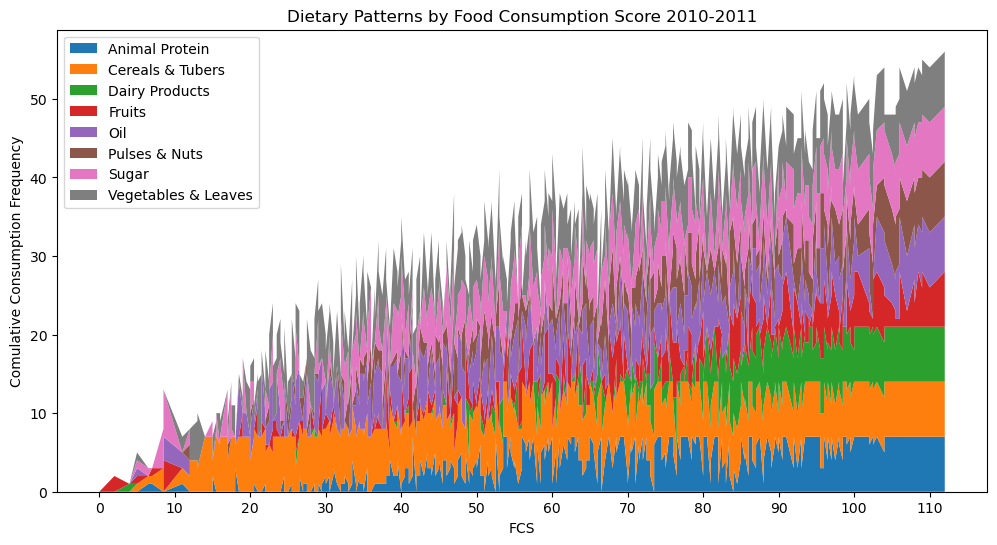

In [38]:
plot_food_consumption(data_fcs, year='2010-2011', save_path='Tanzania/graphs/dp2010_2011.png')

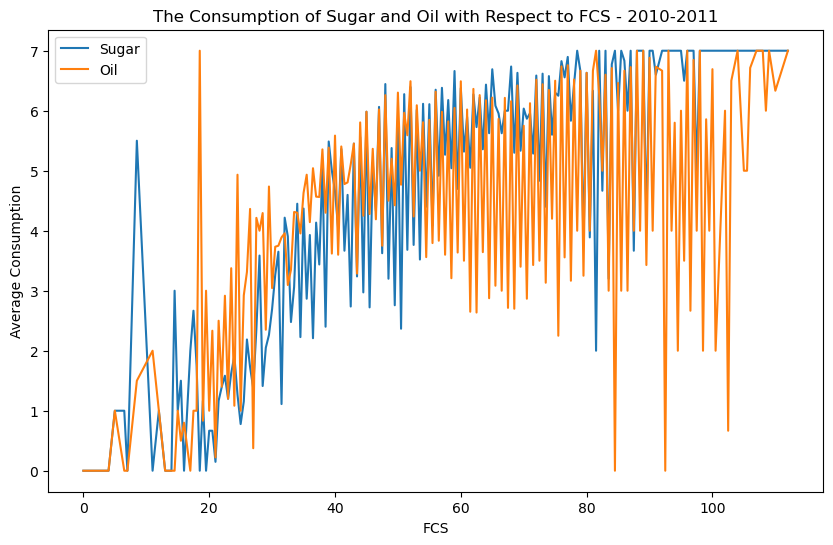

In [39]:
visualize_fcs_with_oil_sugar(data_fcs,'2010-2011',save_path='Tanzania/graphs/so2010_2011.png')

In [40]:
#save the file may be useful later
data_fcs.to_csv(dir_2010_2011+ 'tz_2010_2011_fcs.csv', index=False)

#### Compute HDDS

In [41]:
#call the function to compute the fcs
data_hdds = calculate_hdds(data)
data_hdds.head()

83 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,hdds
0,101014002017101,1,1,1,0,1,1,1,1,1,8
1,101014002028401,1,1,1,1,1,1,1,1,1,9
2,101014002029701,1,1,1,1,1,1,1,1,1,9
3,101014002029704,1,1,1,1,1,1,1,1,1,9
4,101014002040901,1,1,1,0,0,1,1,1,1,7


In [42]:
#save the file may be useful later
data_hdds.to_csv(dir_2010_2011+'tz_2010_2011_hdds.csv', index=False)

#### Combine the data files

In [43]:
#merging the location,fcs and hdds dataframe
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,original_year,year,hhid,region,district,fcs,hdds
0,2011,2010/2011,701018004011501,Dar es Salaam,Kinondoni,0.0,1
1,2010,2010/2011,701009049002901,Dar es Salaam,Kinondoni,2.0,1
2,2010,2010/2011,905001004002501,Mtwara,Mtwara Urban,2.0,1
3,2010,2010/2011,702009028000601,Dar es Salaam,Temeke,4.0,1
4,2011,2010/2011,304014003058501,Kilimanjaro,Moshi Rural,5.0,6
5,2011,2010/2011,1106009307000201,Iringa,Iringa Urban,6.5,3
6,2010,2010/2011,701009049009908,Dar es Salaam,Kinondoni,7.0,4
7,2010,2010/2011,703020006005103,Dar es Salaam,Temeke,8.5,3
8,2010,2010/2011,703018007002201,Dar es Salaam,Temeke,8.5,4
9,2011,2010/2011,701006104000608,Dar es Salaam,Kinondoni,11.0,4


In [44]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2010_2011+'tz_2010_2011_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [45]:
agg_data= calculate_mean(data_merged, ['year','region','district'],['fcs','hdds'])
agg_data.head()

,year,region,district,fcs,hdds,count
0,2010/2011,Arusha,Arusha,65.29,8.14,7
1,2010/2011,Arusha,Arusha Urban,68.51,8.38,40
2,2010/2011,Arusha,Karatu,52.47,7.40,15
3,2010/2011,Arusha,Meru,69.47,8.15,20
4,2010/2011,Arusha,Monduli,52.05,6.16,19


In [46]:
#save the final dataset
agg_data.to_csv(dir_2010_2011+'tz_2010_2011_final.csv', index=False)

## National Panel Survey 2012 - 2013

This dataset is public available on [National Panel Survey(NPS) 2012 - 2013](https://microdata.worldbank.org/index.php/catalog/2252). The NPS interviewed 3,924households spanning all regions and all districts of Tanzania, both mainland and Zanzibar.The dataset containing data related to Household questionnaire, Agriculture questionnaire, Fishery & Livestock questionnaire and Community questionnaire which cover broad range of the topics. For more discription about the coverage of the topics in this dataset [Click Here](https://microdata.worldbank.org/index.php/catalog/2252/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.worldbank.org/index.php/catalog/2252/data-dictionary)

#### Loading the data sources

The data files we have use in the dataset are those named:
* HH_SEC_A.dta : Contain the description about the address of the household which is identified by a unique identification (hhid)
* HH_SEC_J3.dta : Contain the data information about food consumption of 7 days recall

These files are in stata format, therefore we need to change them into csv format for easily manipulation

In [47]:
#define data directory
dir_2012_2013 = 'Tanzania/2012_2013/tanzania_2012_2013_preprocessed_data/'

In [ ]:
''''
#convert HH_SEC_A.dta to csv file
o_path= dir_2012_2013 +'HH_SEC_A.dta'
u_path = dir_2012_2013+'HH_SEC_A.csv'

dta_to_csv(o_path,u_path) #call the function to convert

#convert HH_SEC_J3.dta to csv file
o_path= dir_2012_2013+'HH_SEC_J3.dta'
u_path = dir_2012_2013+'HH_SEC_J3.csv'

dta_to_csv(o_path,u_path) #call the function to convert

'''

In [48]:
#Load the data file containing the food items consumed by each household the file is generated from HH_SEC_J3.csv 
data =  read_csv(dir_2012_2013+'tz_2012_2013_food_consumed.csv', header=0,delimiter=',')
data.head()

,hhid,food_code,food_group,is_consumed
0,0001-001,A,cereals_tubers,7
1,0001-001,B,cereals_tubers,0
2,0001-001,C,pulses_nuts,0
3,0001-001,D,vegetables_leaves,5
4,0001-001,E,animal_protein,3


In [49]:
#Load the data file containing the household address,this file is generated from HH_SEC_A.csv 
location =  read_csv(dir_2012_2013+'tz_2012_2013_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,hhid,year,original_year,region,district,locality
0,3,0001-001,2012/2013,2012,Dodoma,Kondoa,Rural
1,3,0002-001,2012/2013,2012,Dodoma,Kondoa,Rural
2,3,0003-001,2012/2013,2012,Dodoma,Kondoa,Rural
3,3,0003-010,2012/2013,2012,Dar es Salaam,Temeke,Urban
4,3,0005-001,2012/2013,2012,Dodoma,Kondoa,Rural


#### Compute FCS

In [50]:
#call the function to compute the fcs
data_fcs = calculate_fcs(data)
data_fcs.head()

89 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,fcs
0,0001-001,3,7,7,0,0,7,0,0,5,34.5
1,0002-001,0,7,7,0,0,7,0,7,7,28.0
2,0003-001,0,7,7,0,5,7,7,7,7,54.0
3,0003-010,5,7,7,0,2,7,4,7,7,62.0
4,0005-001,7,7,7,1,0,7,6,7,5,76.0


#### Checking For Dietary Patterns of The Population

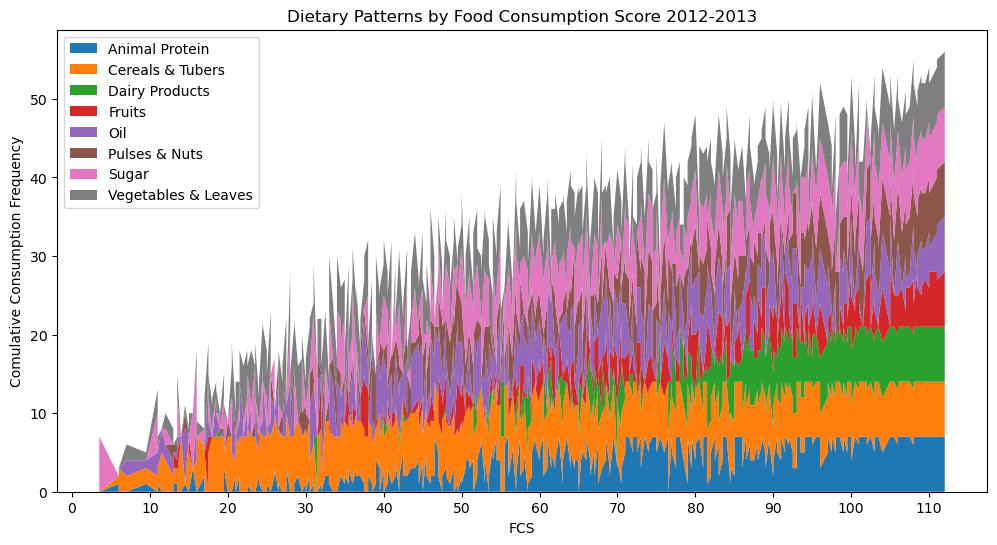

In [51]:
plot_food_consumption(data_fcs, year='2012-2013', save_path='Tanzania/graphs/dp2012_2013.png')

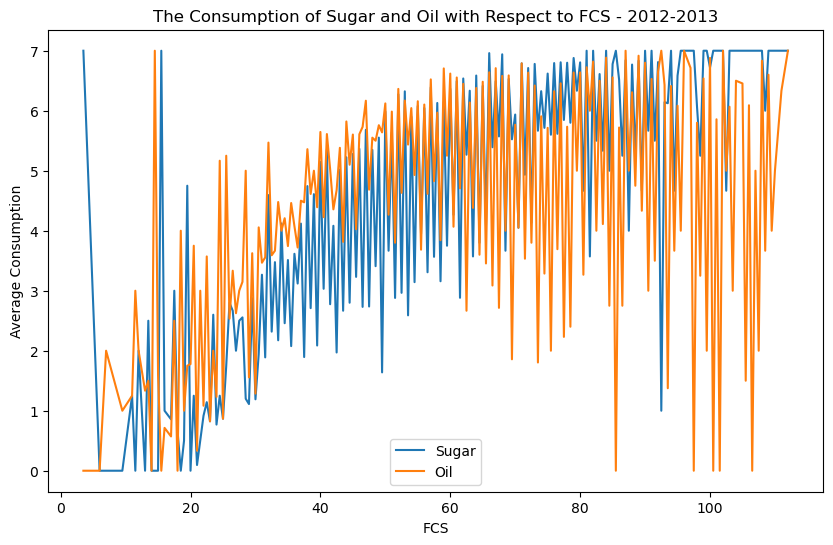

In [52]:
visualize_fcs_with_oil_sugar(data_fcs,'2012-2013',save_path='Tanzania/graphs/so2012_2013.png')

In [53]:
#save the file may be useful later
data_fcs.to_csv(dir_2012_2013+'tz_2012_2013_fcs.csv', index=False)

#### Compute HDDS

In [54]:
#call the function to compute the fcs
data_hdds = calculate_hdds(data)
data_hdds.head()

89 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,hdds
0,0001-001,1,1,1,0,0,1,0,0,1,5
1,0002-001,0,1,1,0,0,1,0,1,1,5
2,0003-001,0,1,1,0,1,1,1,1,1,7
3,0003-010,1,1,1,0,1,1,1,1,1,8
4,0005-001,1,1,1,1,0,1,1,1,1,8


In [55]:
#save the file may be useful later
data_hdds.to_csv(dir_2012_2013+'tz_2012_2013_hdds.csv', index=False)

#### Combine the data files

In [58]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head()

,original_year,year,hhid,region,district,fcs,hdds
0,2013,2012/2013,0368-003,Tanga,Muheza,3.5,2
1,2013,2012/2013,1637-009,Lindi,Lindi Urban,3.5,1
2,2013,2012/2013,1941-002,Dar es Salaam,Kinondoni,3.5,1
3,2013,2012/2013,2085-001,Mbeya,Chunya,6.0,3
4,2012,2012/2013,2223-001,Mbeya,Mbeya Urban,6.0,1


In [59]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2012_2013+'tz_2012_2013_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [60]:
agg_data= calculate_mean(data_merged, ['year','region','district'],['fcs','hdds'])
agg_data.head()

,year,region,district,fcs,hdds,count
0,2012/2013,Arusha,Arusha,67.00,8.00,8
1,2012/2013,Arusha,Arusha Urban,61.51,7.72,54
2,2012/2013,Arusha,Karatu,69.61,7.94,18
3,2012/2013,Arusha,Meru,63.50,8.00,21
4,2012/2013,Arusha,Monduli,59.90,7.00,26


In [61]:
agg_data.to_csv(dir_2012_2013+'tz_2012_2013_final.csv', index=False)

## National Panel Survey 2014 - 2015

This dataset is public available on [National Panel Survey(NPS) 2014 - 2015](https://microdata.worldbank.org/index.php/catalog/2862). The NPS interviewed 3,360 households spanning all Dar es Salaam,Other Urban,Rural and Zanzibar.The dataset containing data related to Household questionnaire, Agriculture questionnaire and Community questionnaire which cover broad range of the topics. For more discription about the coverage of the topics in this dataset [Click Here](https://microdata.worldbank.org/index.php/catalog/2862/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.worldbank.org/index.php/catalog/2862/data-dictionary)

#### Loading the data sources

The data files we have use in the dataset are those named:
* hh_sec_a.dta : Contain the description about the address of the household which is identified by a unique identification (hhid)
* hh_sec_j3.dta : Contain the data information about food consumption of 7 days recall

These files are in stata format, therefore we need to change them into csv format for easily manipulation

In [62]:
#define data directory
dir_2014_2015 = 'Tanzania/2014_2015/tanzania_2014_2015_preprocessed_data/'

In [ ]:
'''
#convert hh_sec_a.dta to csv file
o_path = dir_2014_2015+'hh_sec_a.dta'
u_path = dir_2014_2015+'hh_sec_a.csv'

dta_to_csv(o_path,u_path) #call the function to convert

#convert hh_sec_j3.dta to csv file
o_path= dir_2014_2015+'hh_sec_j3.dta'
u_path = dir_2014_2015+'hh_sec_j3.csv'

dta_to_csv(o_path,u_path) #call the function to convert

'''

In [63]:
data =  read_csv(dir_2014_2015+'tz_2014_2015_food_consumed.csv', header=0,delimiter=',')
data.head()

,hhid,food_code,food_group,is_consumed
0,1000-001,A,cereals_tubers,7.0
1,1000-001,B,cereals_tubers,2.0
2,1000-001,C,pulses_nuts,3.0
3,1000-001,D,vegetables_leaves,7.0
4,1000-001,E,animal_protein,2.0


In [64]:
#read the file containing the location of the household 
location =  read_csv(dir_2014_2015+'tz_2014_2015_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,hhid,year,original_year,region,district,locality
0,4,1000-001,2014/2015,2014,Arusha,Meru,Rural
1,4,1001-001,2014/2015,2014,Arusha,Meru,Rural
2,4,1002-001,2014/2015,2014,Arusha,Meru,Rural
3,4,1003-001,2014/2015,2014,Arusha,Meru,Rural
4,4,1005-001,2014/2015,2014,Arusha,Meru,Rural


#### Compute FCS

In [65]:
#call the function to compute the fcs
data_fcs = calculate_fcs(data)
data_fcs.head()

21 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,fcs
0,1000-001,2,7,7,1,0,7,3,7,7,49.0
1,1001-001,2,7,7,7,0,7,3,7,7,73.0
2,1002-001,0,7,7,7,0,7,7,7,7,77.0
3,1003-001,1,7,7,7,0,7,5,7,3,71.0
4,1005-001,2,7,7,7,0,7,1,7,7,67.0


#### Checking For Dietary Patterns of The Population

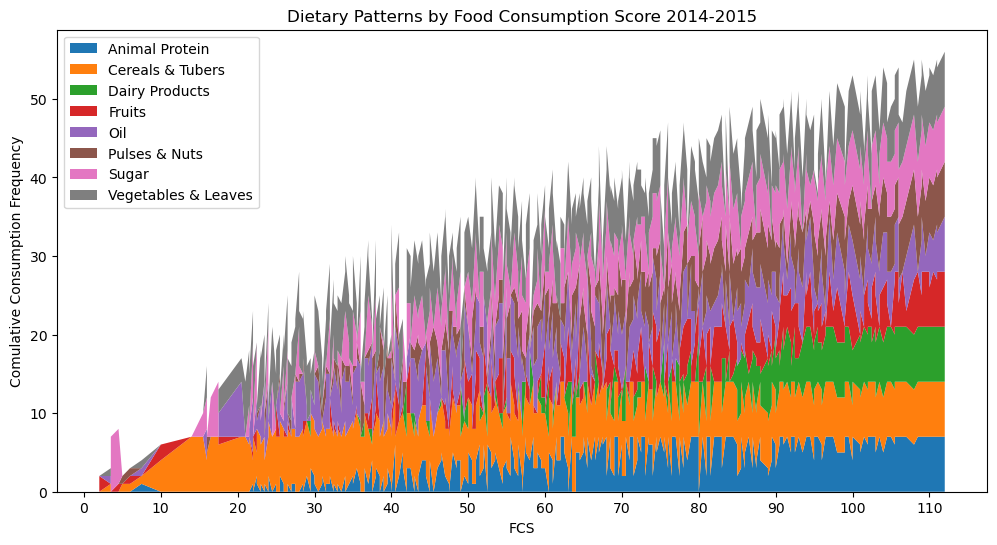

In [66]:
plot_food_consumption(data_fcs, year='2014-2015', save_path='Tanzania/graphs/dp2014_2015.png')

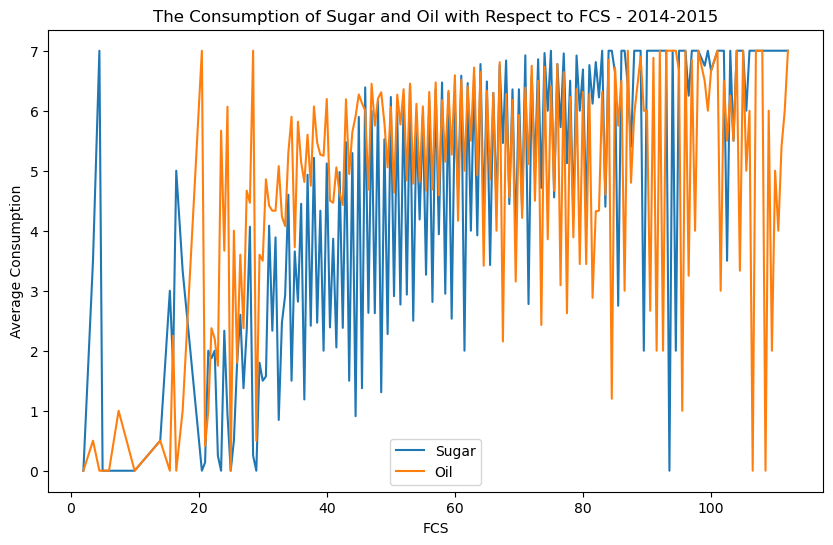

In [67]:
visualize_fcs_with_oil_sugar(data_fcs,'2014-2015',save_path='Tanzania/graphs/so2014_2015.png')

In [68]:
#save the file may be useful later
data_fcs.to_csv(dir_2014_2015+'tz_2014_2015_fcs.csv', index=False)

#### Compute HDDS

In [69]:
#call the function to compute the fcs
data_hdds = calculate_hdds(data)
data_hdds.head()

21 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,hdds
0,1000-001,1,1,1,1,0,1,1,1,1,8
1,1001-001,1,1,1,1,0,1,1,1,1,8
2,1002-001,0,1,1,1,0,1,1,1,1,7
3,1003-001,1,1,1,1,0,1,1,1,1,8
4,1005-001,1,1,1,1,0,1,1,1,1,8


In [70]:
#save the file may be useful later
data_hdds.to_csv(dir_2014_2015+'tz_2014_2015_hdds.csv', index=False)

#### Combine the data files

In [71]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,original_year,year,hhid,region,district,fcs,hdds
0,2015,2014/2015,8092-001,Njombe,Wanging'ombe,2.0,1
1,2015,2014/2015,1461-001,Dar es Salaam,Ilala,3.5,4
2,2014,2014/2015,2826-001,Kusini Unguja,Kusini,3.5,2
3,2014,2014/2015,4176-001,Pwani,Kibaha Urban,4.5,2
4,2014,2014/2015,4292-001,Rukwa,Sumbawanga Urban,5.0,2
5,2015,2014/2015,1652-001,Dar es Salaam,Temeke,6.0,3
6,2014,2014/2015,3661-001,Morogoro,Ulanga,7.5,5
7,2015,2014/2015,4310-001,Ruvuma,Tunduru,10.0,3
8,2015,2014/2015,7767-001,Mtwara,Mtwara Rural,14.0,2
9,2014,2014/2015,2260-001,Kagera,Kyerwa,14.0,2


In [72]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2014_2015+'tz_2014_2015_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [73]:
agg_data= calculate_mean(data_merged, ['year','region','district'],['fcs','hdds'])
agg_data.head()

,year,region,district,fcs,hdds,count
0,2014/2015,Arusha,Arusha,65.66,7.50,16
1,2014/2015,Arusha,Arusha Urban,70.81,8.31,16
2,2014/2015,Arusha,Karatu,61.81,6.38,8
3,2014/2015,Arusha,Longido,42.19,4.88,8
4,2014/2015,Arusha,Meru,73.50,8.42,24


In [74]:
agg_data.to_csv(dir_2014_2015+'tz_2014_2015_final.csv', index=False)

## National Panel Survey 2019 - 2020
This dataset is public available on [National Panel Survey(NPS) 2019 - 2020](https://microdata.worldbank.org/index.php/catalog/3885).The NPS interviewed 1,184 households spanning all regions and all districts of Tanzania, both mainland and Zanzibar. The NPS-SDD 2019/20 is the first Extended Panel with sex-disaggregated data survey, collecting information on a wide range of topics including agricultural production, non-farm income generating activities, individual rights to plots, consumption expenditures, and a wealth of other socioeconomic characteristics. For more discription about the coverage of the topics in this dataset [Click Here](https://microdata.worldbank.org/index.php/catalog/3885/study-description).For our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.worldbank.org/index.php/catalog/3885/data-dictionary)

#### Loading the data sources

The data files we have use in the dataset are those named:
* HH_SEC_A.dta : Contain the description about the address of the household which is identified by a unique identification (hhid)
* HH_SEC_J3.dta : Contain the data information about food consumption of 7 days recall

These files are in stata format, therefore we need to change them into csv format for easily manipulation

In [75]:
#define data directry
dir_2019_2020 = 'Tanzania/2019_2020/tanzania_2019_2020_preprocessed_data/'

In [ ]:
'''
#convert HH_SEC_A.dta to csv file
o_path= dir_2019_2020+'HH_SEC_A.dta'
u_path = dir_2019_2020+'HH_SEC_A.csv'

dta_to_csv(o_path,u_path) #call the function to convert

#convert HH_SEC_J3.dta to csv file
o_path= dir_2019_2020+'HH_SEC_J3.dta'
u_path = dir_2019_2020+'HH_SEC_J3.csv'

dta_to_csv(o_path,u_path) #call the function to convert

'''

In [76]:
data = read_csv(dir_2019_2020+'tz_2019_2020_food_consumed.csv', header=0,delimiter=',')
data.head()

,hhid,food_code,food_group,is_consumed
0,0001-001-001,A,cereals_tubers,7.0
1,0001-001-001,B,cereals_tubers,1.0
2,0001-001-001,C,pulses_nuts,0.0
3,0001-001-001,D,vegetables_leaves,5.0
4,0001-001-001,E,animal_protein,1.0


In [77]:
#read the file containing the location of the household 
location = read_csv(dir_2019_2020+'tz_2019_2020_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,hhid,year,original_year,region,district,locality
0,5,0001-001-001,2019/2020,2019,Dodoma,Kondoa,Rural
1,5,0001-001-003,2019/2020,2019,Dodoma,Chemba,Rural
2,5,0001-001-004,2019/2020,2019,Dar es Salaam,Kinondoni,Urban
3,5,0001-004-001,2019/2020,2019,Dodoma,Kondoa,Rural
4,5,0001-004-002,2019/2020,2019,Dodoma,Kondoa,Urban


#### Compute FCS

In [78]:
#call the function to compute the fcs
data_fcs = calculate_fcs(data)
data_fcs.head()

48 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,fcs
0,0001-001-001,1,7,7,0,0,7,0,5,5,29.0
1,0001-001-003,6,7,7,1,0,7,2,0,7,58.5
2,0001-001-004,3,7,7,1,2,7,3,7,3,51.0
3,0001-004-001,2,7,7,5,0,7,3,7,5,63.0
4,0001-004-002,3,7,7,0,0,7,0,0,7,36.5


#### Checking For Dietary Patterns of The Population

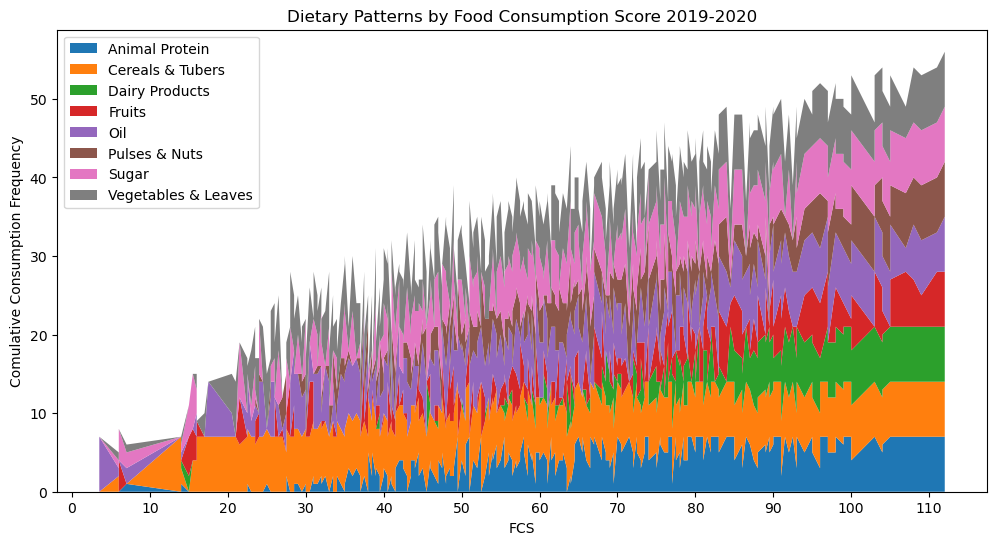

In [79]:
plot_food_consumption(data_fcs, year='2019-2020', save_path='Tanzania/graphs/dp2019_2020.png')

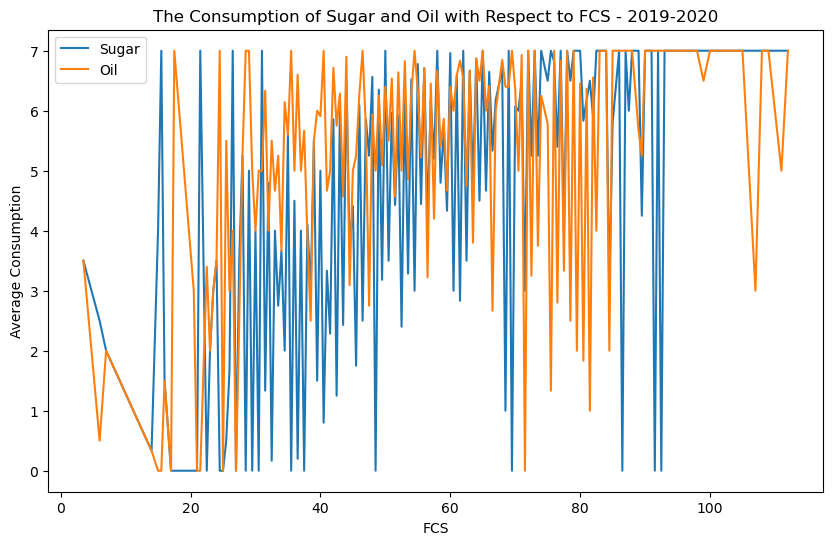

In [80]:
visualize_fcs_with_oil_sugar(data_fcs,'2019-2020',save_path='Tanzania/graphs/so2019_2020.png')

In [81]:
#save the data may be useful later 
data_fcs.to_csv(dir_2019_2020+'tz_2019_2020_fcs.csv',index=False)

#### Compute HDDS

In [82]:
#call the function to compute the fcs
data_hdds = calculate_hdds(data)
data_hdds.head()

48 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,hdds
0,0001-001-001,1,1,1,0,0,1,0,1,1,6
1,0001-001-003,1,1,1,1,0,1,1,0,1,7
2,0001-001-004,1,1,1,1,1,1,1,1,1,9
3,0001-004-001,1,1,1,1,0,1,1,1,1,8
4,0001-004-002,1,1,1,0,0,1,0,0,1,5


In [83]:
data_hdds.to_csv(dir_2019_2020+'tz_2019_2020_hdds.csv',index=False)

#### Combine the data files

In [84]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,original_year,year,hhid,region,district,fcs,hdds
0,2019.0,2019/2020,0066-003-004,Mwanza,Ilemela,3.5,1
1,2019.0,2019/2020,0268-001-001,Pwani,Rufiji,3.5,1
2,2019.0,2019/2020,0680-001-001,Kagera,Bukoba Urban,6.0,5
3,2019.0,2019/2020,0792-002-002,Mjini Magharibi,Magharibi,6.0,2
4,2019.0,2019/2020,0551-001-003,Tabora,Urambo,7.0,5
5,2019.0,2019/2020,0555-001-001,Tabora,Tabora,14.0,2
6,2019.0,2019/2020,0634-001-001,Shinyanga,Kahama,14.0,2
7,2019.0,2019/2020,0687-006-002,Mwanza,Nyamagana,14.0,7
8,2019.0,2019/2020,0443-005-001,Iringa,Mufindi,15.0,3
9,2019.0,2019/2020,0075-001-003,Tanga,Lushoto,15.5,3


In [85]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2019_2020+'tz_2019_2020_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [86]:
agg_data= calculate_mean(data_merged, ['year','region','district'],['fcs','hdds'])
agg_data.head()

,year,region,district,fcs,hdds,count
0,2019/2020,Arusha,Arusha Urban,57.50,7.89,9
1,2019/2020,Arusha,Karatu,54.90,7.00,10
2,2019/2020,Arusha,Monduli,62.00,9.00,1
3,2019/2020,Dar es Salaam,Ilala,70.64,8.14,29
4,2019/2020,Dar es Salaam,Kinondoni,63.20,8.00,89


In [87]:
agg_data.to_csv(dir_2019_2020+'tz_2019_2020_final.csv',index=False)

## National Panel Survey 2020 - 2022

This dataset is public available on [National Panel Survey(NPS) 2020 - 2022](https://microdata.worldbank.org/index.php/catalog/5639). The NPS interviewed 4,709 households spanning some regions such as Dar es Salaam, Other Urban,Rural and Zanzibar.The dataset containing data related to Household questionnaire, Agriculture questionnaire and Community questionnaire which cover broad range of the topics. For more discription about the coverage of the topics in this dataset [Click Here](https://microdata.worldbank.org/index.php/catalog/5639/study-description). The dataset consinst of multiples files, however for our task we will mostly focus on HouseHold Questionnaire, for more description about the data definition of each files and their associate variables [Visit Here](https://microdata.worldbank.org/index.php/catalog/5639/data-dictionary)

#### Loading the data sources

The data files we have use in the dataset are those named:
* hh_sec_a.dta : Contain the description about the address of the household which is identified by a unique identification (hhid)
* hh_sec_j3.dta : Contain the data information about food consumption of 7 days recall

These files are in stata format, therefore we need to change them into csv format for easily manipulation

In [88]:
#define data directory
dir_2020_2022 = 'Tanzania/2020_2022/tanzania_2020_2022_preprocessed_data/'

In [ ]:
'''
#convert hh_sec_a.dta to csv file
o_path= dir_2020_2022+'hh_sec_a.dta'
u_path = dir_2020_2022+'hh_sec_a.csv'
dta_to_csv(o_path,u_path) #call the function to convert


#convert hh_sec_j3.dta to csv file
o_path= dir_2020_2022+'hh_sec_j3.dta'
u_path = dir_2020_2022+'hh_sec_j3.csv'
dta_to_csv(o_path,u_path) #call the function to convert

'''

In [89]:
data = read_csv(dir_2020_2022+'tz_2020_2022_food_consumed.csv', header=0,delimiter=',')
data.head()

,hhid,food_code,food_group,is_consumed
0,1000-001-01,"A. CEREALS, GRAINS AND CEREAL PRODUCTS",cereals_tubers,7
1,1000-001-01,"B. ROOTS, TUBERS, AND PLANTAINS",cereals_tubers,4
2,1000-001-01,C. NUTS AND PULSES,pulses_nuts,7
3,1000-001-01,D. VEGETABLES,vegetables_leaves,7
4,1000-001-01,"E. MEAT, FISH AND ANIMAL PRODUCTS",animal_protein,2


In [90]:
#read the file containing the location of the household 
location =  read_csv(dir_2020_2022+'tz_2020_2022_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,hhid,year,original_year,region,district,locality
0,6,1000-001-01,2020/2022,2021,Arusha,Meru,Rural
1,6,1000-001-02,2020/2022,2021,Arusha,Meru,Rural
2,6,1000-001-03,2020/2022,2021,Arusha,Meru,Rural
3,6,1000-001-06,2020/2022,2021,Arusha,Meru,Rural
4,6,1001-001-01,2020/2022,2021,Arusha,Meru,Rural


#### Compute FCS

In [91]:
#call the function to compute the fcs
data_fcs = calculate_fcs(data)
data_fcs.head()

137 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,fcs
0,1000-001-01,2,7,7,0,0,7,7,7,7,57.0
1,1000-001-02,0,7,0,3,0,0,0,0,7,33.0
2,1000-001-03,3,7,7,7,1,7,2,7,7,75.0
3,1000-001-06,4,7,7,2,4,7,7,7,7,77.0
4,1001-001-01,0,7,7,7,0,7,7,7,7,77.0


#### Checking For Dietary Patterns of The Population

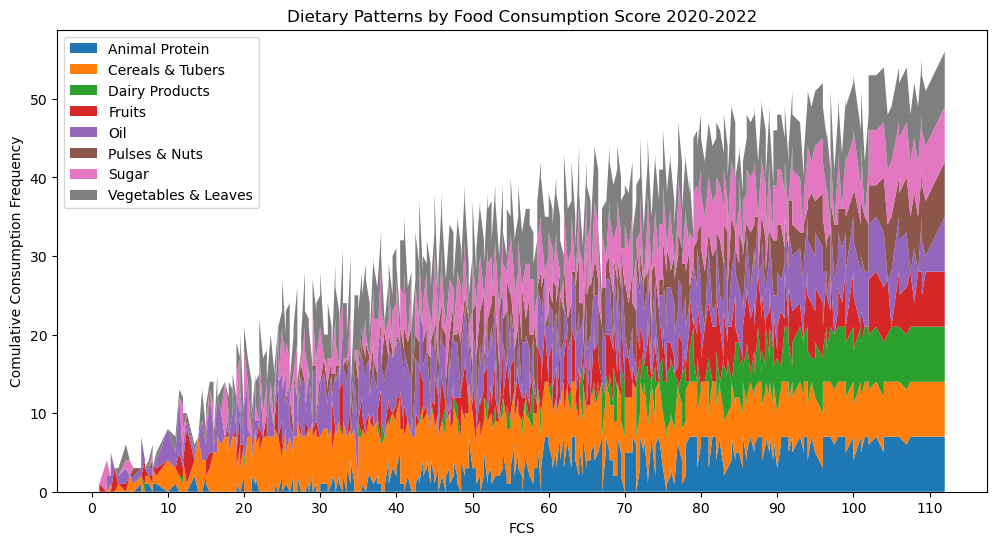

In [92]:
plot_food_consumption(data_fcs, year='2020-2022', save_path='Tanzania/graphs/dp2020_2022.png')

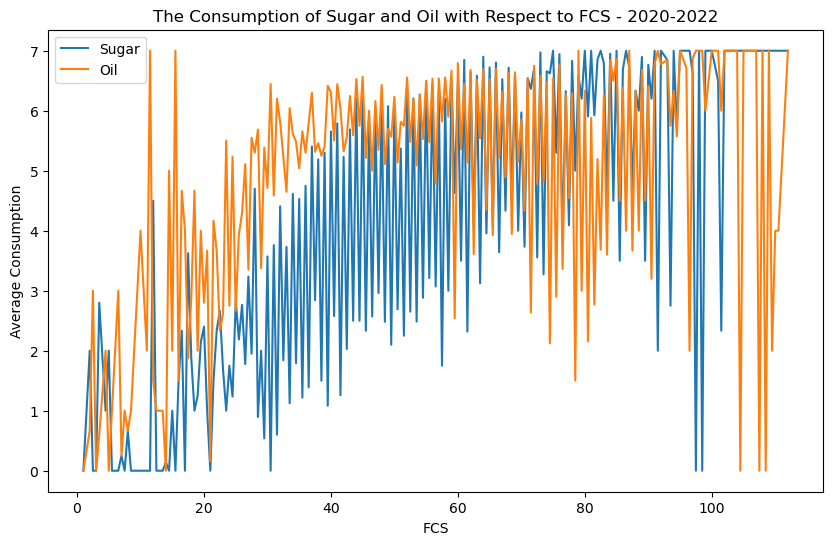

In [93]:
visualize_fcs_with_oil_sugar(data_fcs,'2020-2022',save_path='Tanzania/graphs/so2020_2022.png')

In [94]:
data_fcs.to_csv(dir_2020_2022+'tz_2020_2022_fcs.csv', index = False )

#### Compute HDDS

In [95]:
#call the function to compute the hdds
data_hdds = calculate_hdds(data)
data_hdds.head()

137 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,hdds
0,1000-001-01,1,1,1,0,0,1,1,1,1,7
1,1000-001-02,0,1,0,1,0,0,0,0,1,3
2,1000-001-03,1,1,1,1,1,1,1,1,1,9
3,1000-001-06,1,1,1,1,1,1,1,1,1,9
4,1001-001-01,0,1,1,1,0,1,1,1,1,7


In [96]:
#save the file may be useful later
data_hdds.to_csv(dir_2020_2022+'tz_2020_2022_hdds.csv', index=False)

#### Combine the data files

In [97]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,original_year,year,hhid,region,district,fcs,hdds
0,2021,2020/2022,3660-001-10,Morogoro,Ulanga,1.0,1
1,2021,2020/2022,1710-001-01,Dar es Salaam,Temeke,2.0,2
2,2021,2020/2022,4687-001-01,Singida,Singida Urban,2.0,1
3,2021,2020/2022,6023-001-01,Iringa,Iringa Urban,2.0,3
4,2020,2020/2022,1350-001-04,Dar es Salaam,Kinondoni,2.5,3
5,2021,2020/2022,1500-001-03,Dar es Salaam,Ilala,2.5,2
6,2020,2020/2022,3338-001-06,Kusini Unguja,Kati,3.0,1
7,2021,2020/2022,1044-001-01,Arusha,Arusha Urban,3.5,4
8,2021,2020/2022,6321-001-01,Kaskazini Pemba,Wete,3.5,1
9,2021,2020/2022,5280-001-01,Dar es Salaam,Ilala,3.5,4


In [98]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2020_2022+'tz_2020_2022_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [99]:
agg_data= calculate_mean(data_merged, ['year','region','district'],['fcs','hdds'])
agg_data.head()

,year,region,district,fcs,hdds,count
0,2020/2022,Arusha,Arusha,61.88,7.50,20
1,2020/2022,Arusha,Arusha Urban,59.39,7.93,130
2,2020/2022,Arusha,Karatu,59.60,6.20,5
3,2020/2022,Arusha,Longido,65.00,7.25,8
4,2020/2022,Arusha,Meru,68.73,8.06,32


In [100]:
agg_data.to_csv(dir_2020_2022+'tz_2020_2022_final.csv', index=False)

## High Frequency Welfare Monitoring Phone Survey 2021-2024
This dataset is public available on [High Frequency Welfare Monitoring Phone Survey 2021-2024](https://microdata.worldbank.org/index.php/catalog/4542).The survey aims to address the limitations of traditional large household surveys by implementing a high-frequency phone survey allowing for the collection of key information in a timely and cost-effective manner.It covers a broad range of the topics including Employment, Education, Food Security, Mental Health and others. For more discription about the coverage of the topics in this dataset [Click Here](https://microdata.worldbank.org/index.php/catalog/4542/study-description). This survey focus is done on nine different round and each round cover a particular topic.For our task we will mostly focus on Round 7 Questionnaire which contain the data about food consumption.For more description about the data definition of each files and their associate variables [Visit Here](https://microdata.worldbank.org/index.php/catalog/4542/data-dictionary)

#### Loading the data sources

The data files we have use in the dataset are those named:
* r7_sect_1.sav : Contain the description about the address of the household which is identified by a unique identification (hhid)
* r7_sect_12b.sav : Contain the data information about food consumption of 7 days recall

These files are in SPSS Statistics Data File Format, therefore we need to change them into csv format for easily manipulation

In [101]:
#define data directory
dir_2023 = 'Tanzania/2023/tanzania_2023_preprocessed_data/'

In [ ]:
'''
#convert r7_sect_1.sav to csv file
o_path= dir_2023 +'r7_sect_1.sav'
u_path = dir_2023 + 'r7_sect_1.csv'
sav_to_csv(o_path,u_path) #call the function to convert

#convert r7_sect_12b.sav to csv file
o_path= dir_2023 +'r7_sect_12b.sav'
u_path = dir_2023 + 'r7_sect_12b.csv'
sav_to_csv(o_path,u_path) #call the function to convert

'''

In [102]:
data = read_csv(dir_2023+'tz_2023_food_consumed.csv', header=0,delimiter=',')
data.head()

,hhid,food_code,food_group,is_consumed
0,5770-001,10,cereals_tubers,1
1,5770-001,20,cereals_tubers,2
2,5770-001,30,pulses_nuts,1
3,5770-001,40,dairy_products,1
4,5770-001,50,animal_protein,1


In [103]:
#read the file containing the location of the household 
location =  read_csv(dir_2023+'tz_2023_hhloc.csv', header=0,delimiter=',')
location.head()

,dataset_id,hhid,year,original_year,region,district,locality
0,7,00-57-43-39,2023,2023,Kaskazini Pemba,Micheweni,Rural
1,7,01-04-38-95,2023,2023,Kaskazini Pemba,Wete,Rural
2,7,02-16-34-00,2023,2023,Kaskazini Pemba,Wete,Urban
3,7,03-55-54-81,2023,2023,Kaskazini Unguja,Kaskazini B,Rural
4,7,03-65-58-77,2023,2023,Kaskazini Pemba,Micheweni,Rural


#### Compute FCS

In [104]:
#call the function to compute the fcs
data_fcs = calculate_fcs(data)
data_fcs.head()

1 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,fcs
0,03-65-58-77,0,7,7,1,0,3,2,7,4,33.0
1,06-72-00-17,3,7,0,0,4,0,0,0,3,33.0
2,08-72-39-21,2,5,2,0,3,0,1,1,5,29.5
3,09-19-46-29,7,7,7,0,4,0,2,0,0,52.0
4,1001-001,4,7,7,7,7,7,5,7,7,94.0


#### Checking For Dietary Patterns of The Population

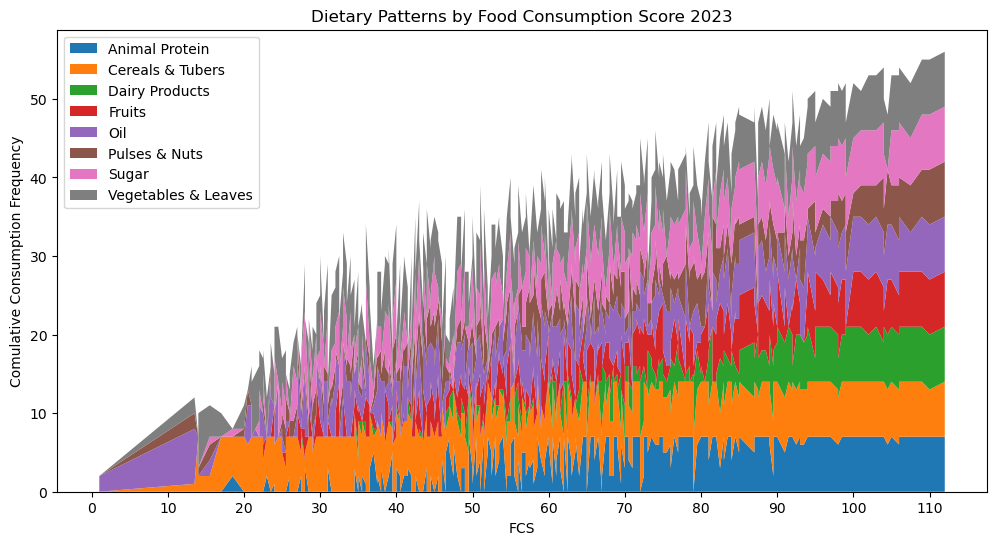

In [105]:
plot_food_consumption(data_fcs, year='2023', save_path='Tanzania/graphs/dp2023.png')

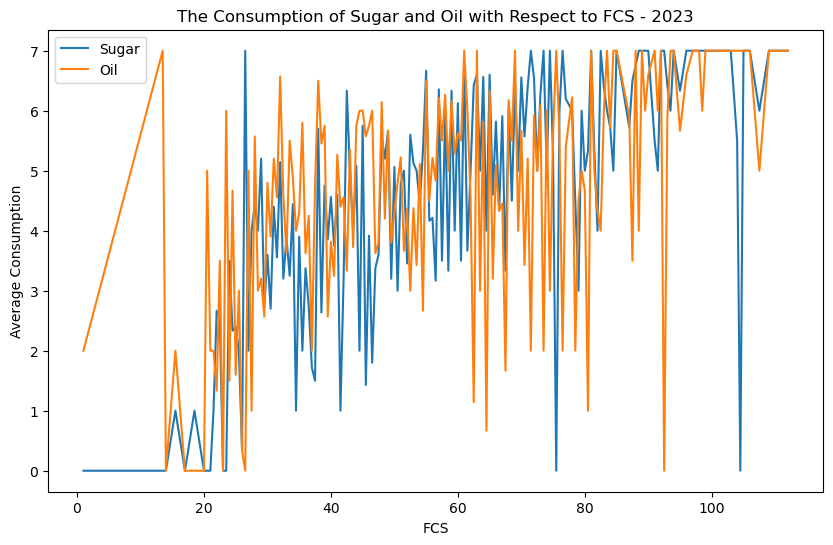

In [106]:
visualize_fcs_with_oil_sugar(data_fcs,'2023',save_path='Tanzania/graphs/so2023.png')

In [107]:
data_fcs.to_csv(dir_2023+'tz_2023_fcs.csv', index = False )

#### Compute HDDS

In [108]:
#call the function to compute the hdds
data_hdds = calculate_hdds(data)
data_hdds.head()

1 row(s) with all specified columns being 0 have been deleted.


food_group,hhid,animal_protein,cereals_tubers,condiments,dairy_products,fruits,oil,pulses_nuts,sugar,vegetables_leaves,hdds
0,03-65-58-77,0,1,1,1,0,1,1,1,1,7
1,06-72-00-17,1,1,0,0,1,0,0,0,1,4
2,08-72-39-21,1,1,1,0,1,0,1,1,1,7
3,09-19-46-29,1,1,1,0,1,0,1,0,0,5
4,1001-001,1,1,1,1,1,1,1,1,1,9


In [109]:
#save the file may be useful later
data_hdds.to_csv(dir_2023+'tz_2023_hdds.csv', index=False)

#### Combine the data files

In [110]:
data_merged = merge_data(location,data_fcs,data_hdds)
data_merged.head(10)

,original_year,year,hhid,region,district,fcs,hdds
0,2023,2023,6022-001,Iringa,Iringa Urban,1.0,1
1,2023,2023,1990-001,Iringa,Mufindi,13.5,4
2,2023,2023,5964-001,Iringa,Iringa Rural,14.0,1
3,2023,2023,110309209001047,Iringa,Iringa Urban,14.0,3
4,2023,2023,210219102001020,Manyara,Hanang,15.5,6
5,2023,2023,200711301001041,Mara,Butiama,17.0,3
6,2023,2023,3531-001,Mjini Magharibi,Magharibi,18.5,4
7,2023,2023,32-71-65-57,Kaskazini Pemba,Wete,20.0,3
8,2023,2023,40908102002005,Tanga,Korogwe Town,20.5,4
9,2023,2023,80311102002003,Lindi,Nachingwea,21.0,4


In [111]:
#save the merged dataset may be useful later
data_merged.to_csv(dir_2023+'tz_2023_merged_data.csv', index=False)

#### Compute the Mean FCS and HDDS of Each District

In [112]:
agg_data= calculate_mean(data_merged, ['year','region','district'],['fcs','hdds'])
agg_data.head()

,year,region,district,fcs,hdds,count
0,2023,Arusha,Arusha,56.70,7.40,5
1,2023,Arusha,Arusha Urban,66.04,8.33,12
2,2023,Arusha,Karatu,71.75,7.50,2
3,2023,Arusha,Longido,87.50,7.00,1
4,2023,Arusha,Meru,77.65,8.54,13


In [113]:
agg_data.to_csv(dir_2023+'tz_2023_final.csv', index=False)